In [592]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.decomposition import PCA

#import lightgbm as lgb 

In [309]:
warnings.filterwarnings('ignore')

In [359]:
rs = 32

In [623]:
df = pd.read_csv('online_shoppers_intention.csv')

In [316]:
df.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


___________________________________________________________________________________________________________
Посмотрим на структуру датасета, типы данных столбцов и наличие пропусков:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

12330 строк, пропусков нет - отлично. Проверим столбцы Month, VisitorType, Weekend и Revenue на количество возможных значений

_________________________________________________________________________
Посмотрим количества возможных значений признаков:

In [4]:
print('feature'.ljust(25,' '),'values amount')
for col in df.columns:
    print(col.ljust(25, ' '),len(df[col].value_counts()))

feature                   values amount
Administrative            27
Administrative_Duration   3335
Informational             17
Informational_Duration    1258
ProductRelated            311
ProductRelated_Duration   9551
BounceRates               1872
ExitRates                 4777
PageValues                2704
SpecialDay                6
Month                     10
OperatingSystems          8
Browser                   13
Region                    9
TrafficType               20
VisitorType               3
Weekend                   2
Revenue                   2


Признаки Administrative, Administrative_Duration,
Informational_Duration, ProductRelated, ProductRelated_Duration, 
BounceRates, ExitRates, PageValues - вероятнее всего числовые, 
т к принимают большое количество возможных значений

Типы признаков Informational и Administrative неочеивидны, 
посмотрим на распределения их возможных значений:

In [216]:
df['Informational'].value_counts().sort_index()

0     9699
1     1041
2      728
3      380
4      222
5       99
6       78
7       36
8       14
9       15
10       7
11       1
12       5
13       1
14       2
16       1
24       1
Name: Informational, dtype: int64

<AxesSubplot:xlabel='Informational', ylabel='Count'>

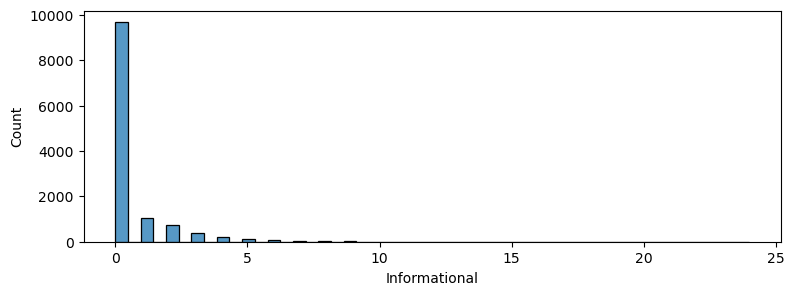

In [222]:
fig = plt.figure(figsize=(9,3))
sns.histplot(df['Informational'],bins=50)

In [230]:
df['Administrative'].value_counts().sort_index()

0     5768
1     1354
2     1114
3      915
4      765
5      575
6      432
7      338
8      287
9      225
10     153
11     105
12      86
13      56
14      44
15      38
16      24
17      16
18      12
19       6
20       2
21       2
22       4
23       3
24       4
26       1
27       1
Name: Administrative, dtype: int64

<AxesSubplot:xlabel='Administrative', ylabel='Count'>

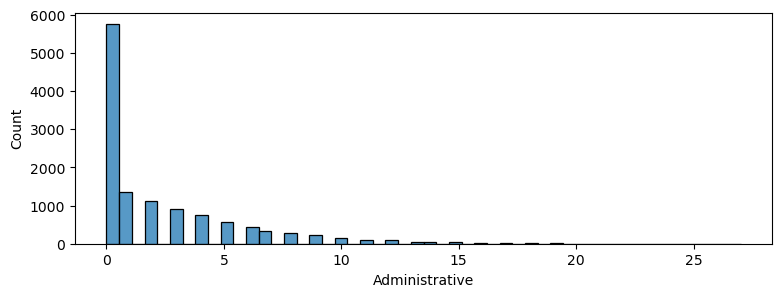

In [231]:
fig = plt.figure(figsize=(9,3))
sns.histplot(df['Administrative'],bins=50)

Распределения не похожи на закодированные наименования категорий.

Вдобавок, внимательнее посмотрим на данный кусок:
    Administrative            27
    Administrative_Duration   3335
    Informational             17
    Informational_Duration    1258
    ProductRelated            311
    ProductRelated_Duration   9551
Скорее всего, признаки Administrative, Informational и ProductRelated обозначают
количества посещенных страниц соответсвующих типов, а признаки
Administrative_Duration, Informational_Duration и ProductRelated_Duration - длительность этих посещений.

Так, будем относиться к ним, как к числовым признакам.

Бинарные  Weekend, Revenue и строковые  Month, VisitorType точно являются категориальными
Судя по наваниям и количествам возможных значений, OperatingSystems, Browser, 
Region, TrafficType, SpecialDay - тоже. Проверим:

In [224]:
df['OperatingSystems'].value_counts().sort_index()

1    2585
2    6601
3    2555
4     478
5       6
6      19
7       7
8      79
Name: OperatingSystems, dtype: int64

In [225]:
df['Browser'].value_counts().sort_index()

1     2462
2     7961
3      105
4      736
5      467
6      174
7       49
8      135
9        1
10     163
11       6
12      10
13      61
Name: Browser, dtype: int64

In [226]:
df['Region'].value_counts().sort_index()

1    4780
2    1136
3    2403
4    1182
5     318
6     805
7     761
8     434
9     511
Name: Region, dtype: int64

In [227]:
df['TrafficType'].value_counts().sort_index()

1     2451
2     3913
3     2052
4     1069
5      260
6      444
7       40
8      343
9       42
10     450
11     247
12       1
13     738
14      13
15      38
16       3
17       1
18      10
19      17
20     198
Name: TrafficType, dtype: int64

In [228]:
df['SpecialDay'].value_counts().sort_index()

0.0    11079
0.2      178
0.4      243
0.6      351
0.8      325
1.0      154
Name: SpecialDay, dtype: int64

Неочевидно, что обозначает SpecialDay. 
Судя по области значений этот признак может обозначать квантиль какой-либо величины.
Будем относиться к нему, как к категориальному, но в случае поступления новых данных
стоит обратить внимание на возможные значения этого признака в новом наборе - если предпололжение,
что признак можно считать категориальным неверно, то нужно будет считать его числовым.

Итого, считаем признаки  Weekend, Revenue, Month,  VisitorType, OperatingSystems, Browser,  Region, TrafficType, SpecialDay 
категориальными, а 
Administrative, Administrative_Duration,  Informational, Informational_Duration, ProductRelated, ProductRelated_Duration, BounceRates, ExitRates, PageValues 
числовыми.

In [236]:
cat_features = ['Weekend', 'Revenue', 'Month', 
                'VisitorType', 'OperatingSystems', 'Browser',  
                'Region', 'TrafficType', 'SpecialDay']

num_features = ['Administrative', 'Administrative_Duration', 'Informational', 
                'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                'BounceRates', 'ExitRates', 'PageValues']

Перед тем, как закодировать категориальные признаки, 
посмотрим на описательные статистики признаков (кроме строковых))


Описательные статистики числовых признаков:

In [237]:
df[num_features].describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742


Описательные стасистики категориальных признаков:

In [244]:
df[cat_features].describe(include=['bool','object'])

,Weekend,Revenue,Month,VisitorType
count,12330,12330,12330,12330
unique,2,2,10,3
top,False,False,May,Returning_Visitor
freq,9462,10422,3364,10551


In [243]:
df[cat_features].describe()

,OperatingSystems,Browser,Region,TrafficType,SpecialDay
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.124006,2.357097,3.147364,4.069586,0.061427
std,0.911325,1.717277,2.401591,4.025169,0.198917
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,2.000000,1.000000,2.000000,0.000000
50%,2.000000,2.000000,3.000000,2.000000,0.000000
75%,3.000000,2.000000,4.000000,4.000000,0.000000
max,8.000000,13.000000,9.000000,20.000000,1.000000


____________

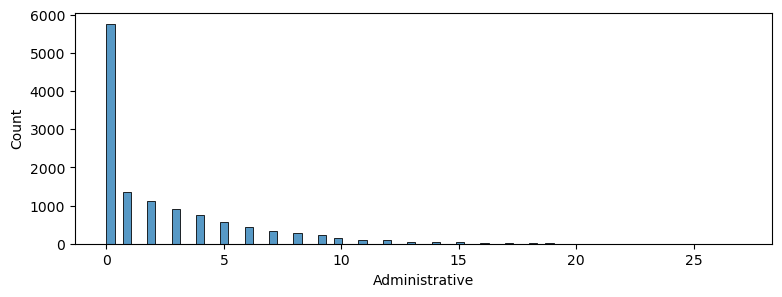

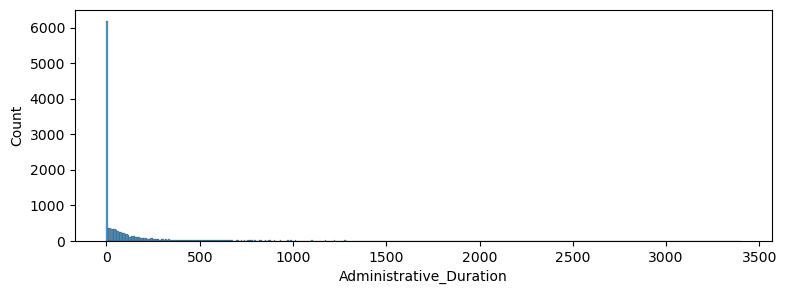

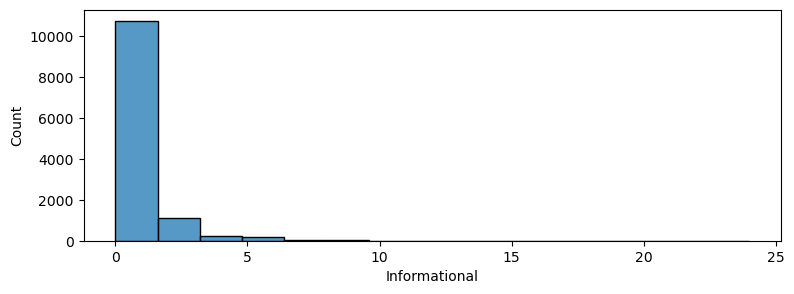

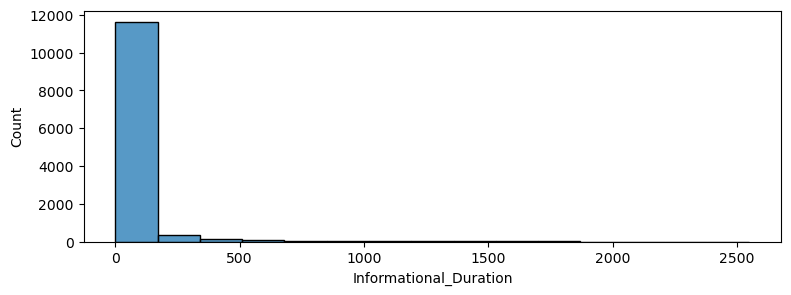

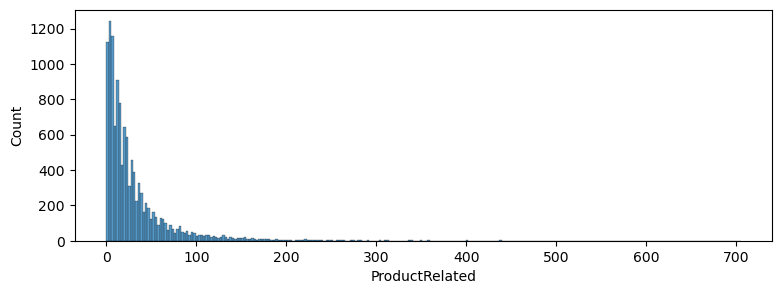

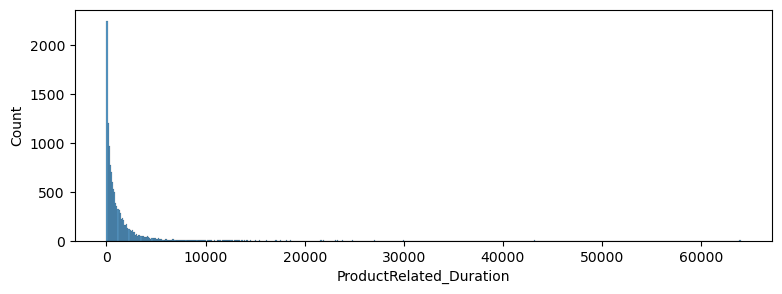

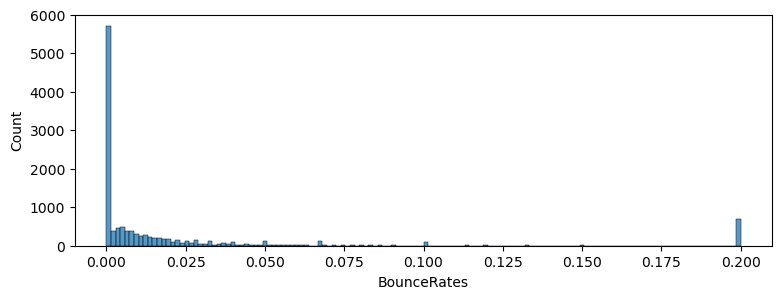

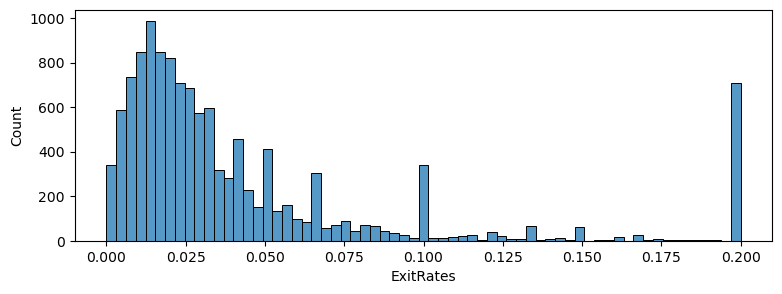

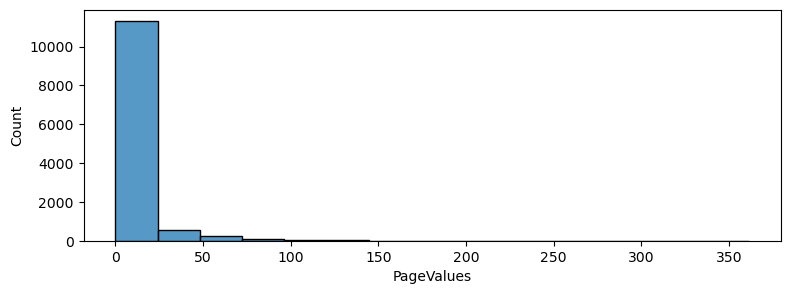

In [315]:
def histplot(feat):
    fig = plt.figure(figsize=(9,3))
    sns.histplot(df[feat])

for col in num_features:
    histplot(col)

_____________________________
Проверим распределения бинарных и категориальных признаков:

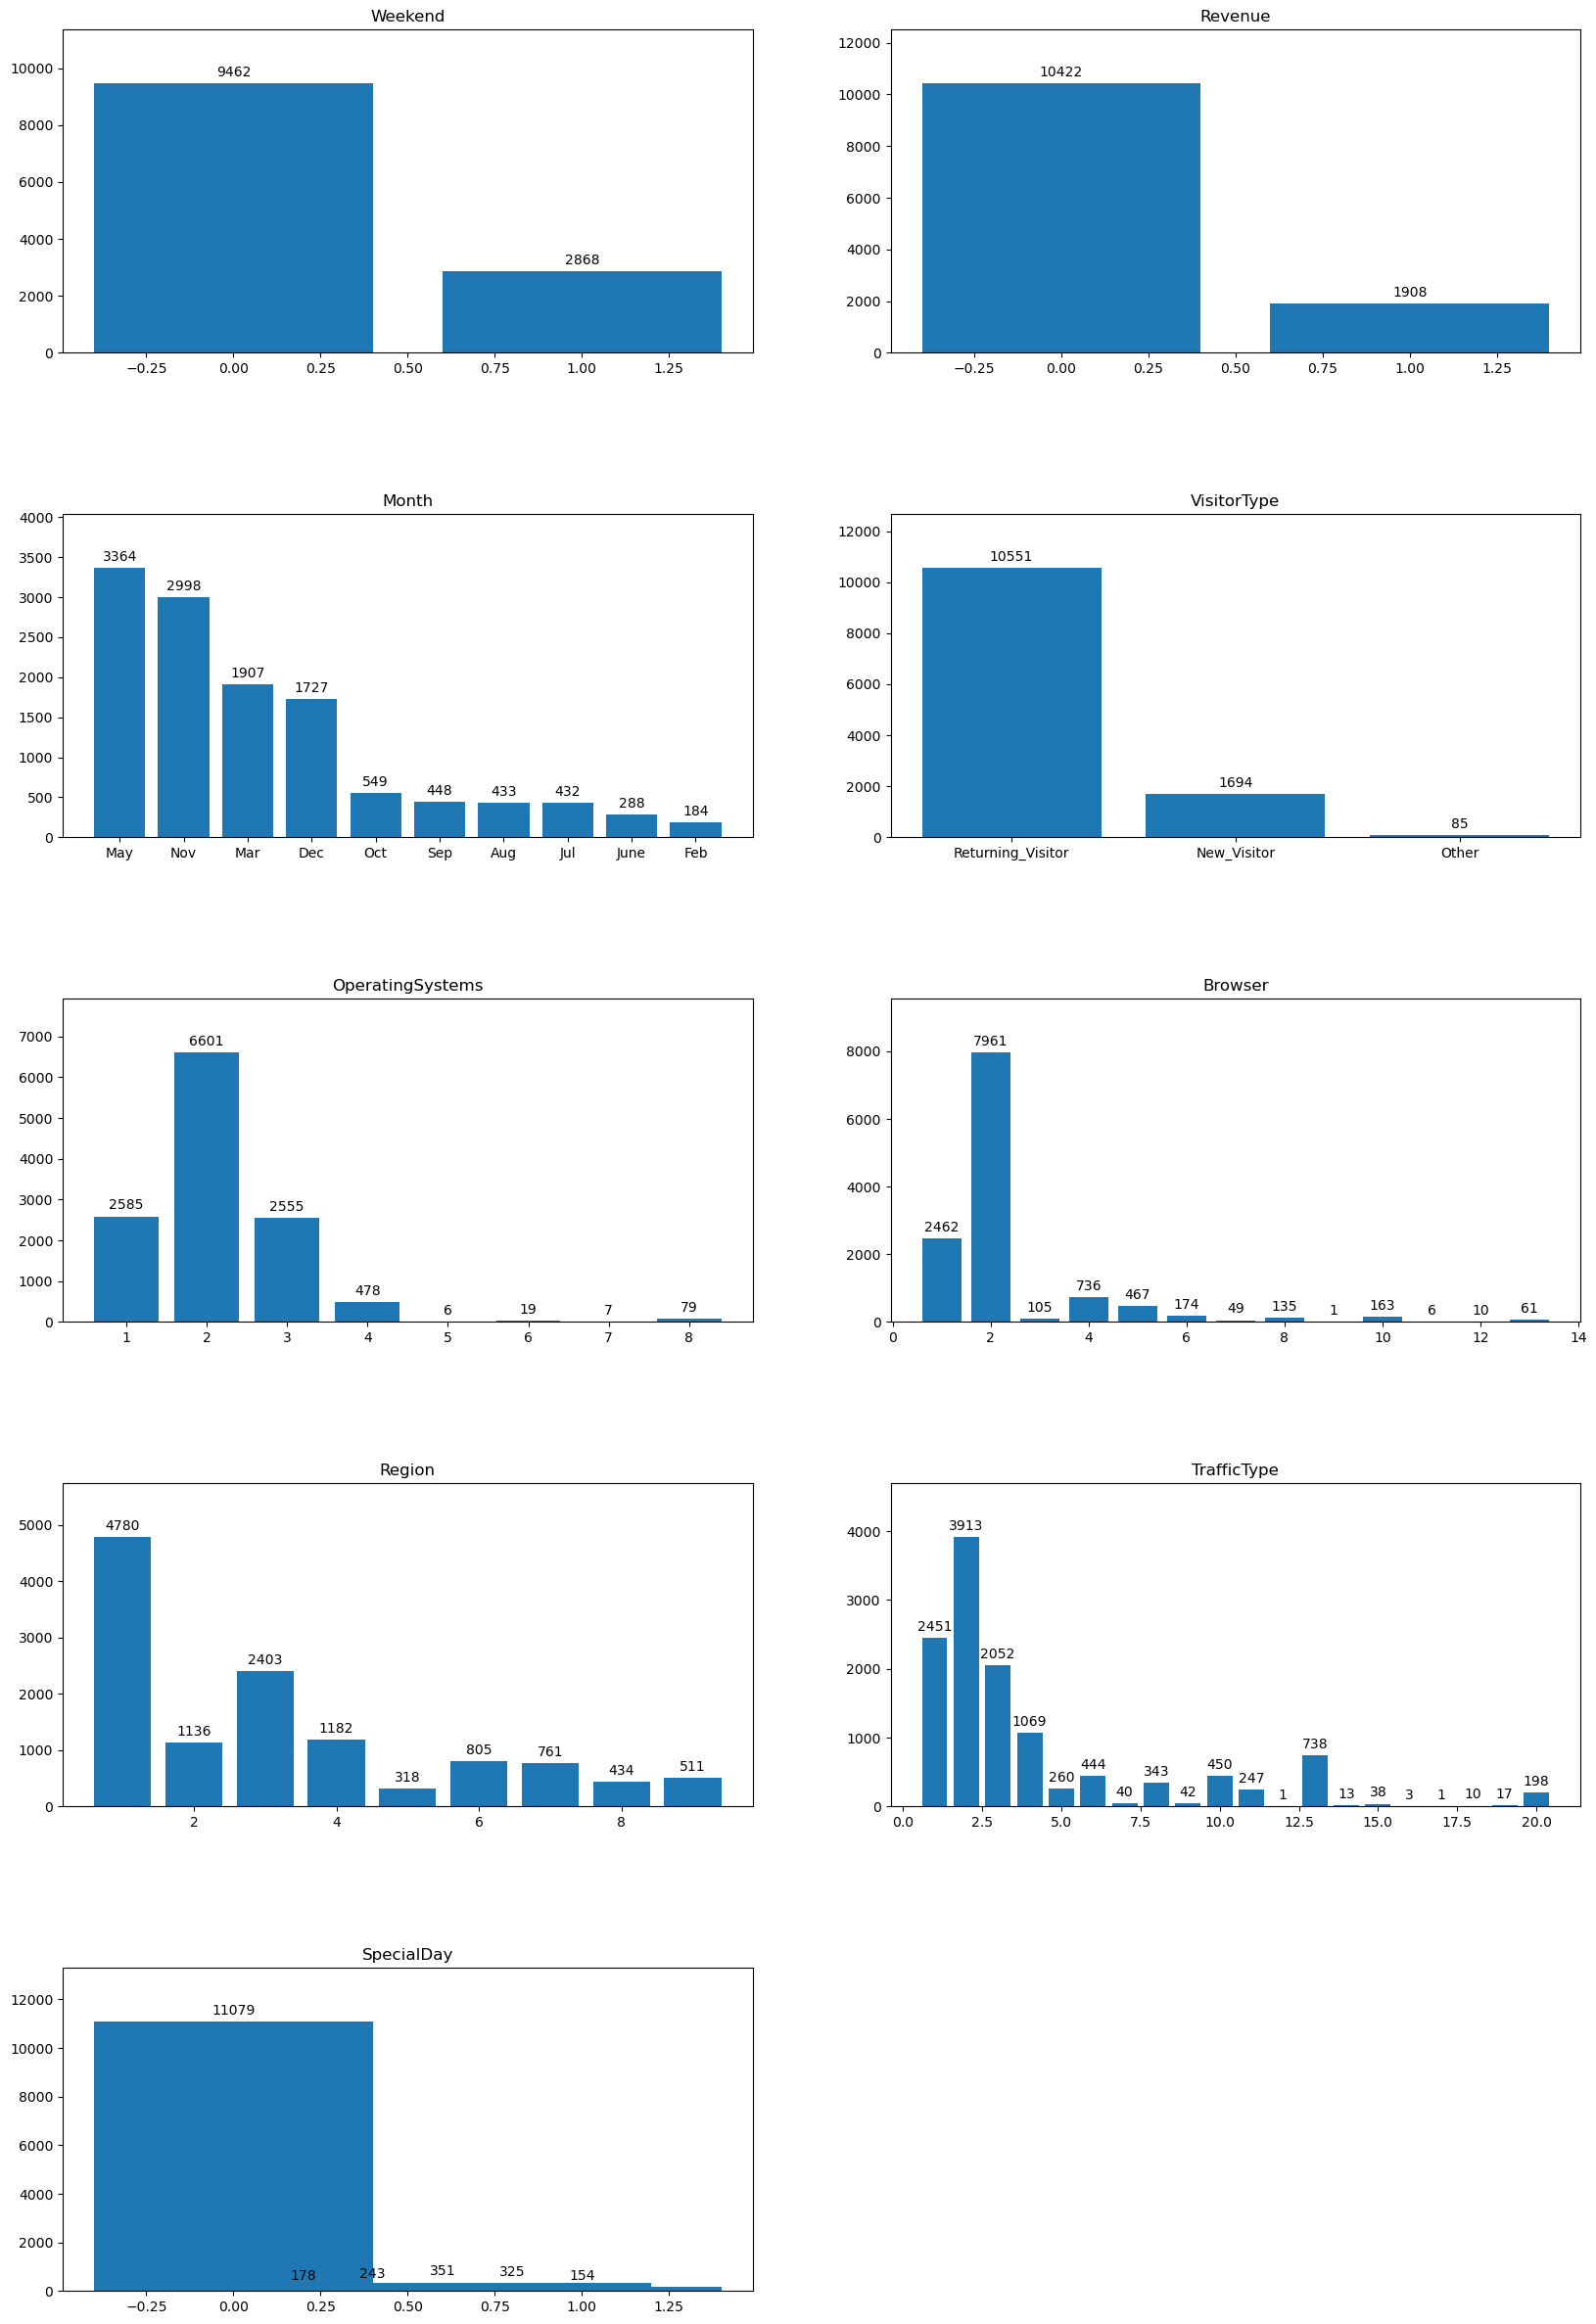

In [255]:
fig = plt.figure(figsize=(20,30))
fig.subplots_adjust(hspace=0.5)

axes = [fig.add_subplot(521),
        fig.add_subplot(522),
        fig.add_subplot(523),
        fig.add_subplot(524),
        fig.add_subplot(525),
        fig.add_subplot(526),
        fig.add_subplot(527),
        fig.add_subplot(528),
        fig.add_subplot(529)]

cols = cat_features

for i in range(len(cols)):
    
    d = dict(df[cols[i]].value_counts())
    bar = axes[i].bar(d.keys(),d.values())
    
    axes[i].set_title(cols[i])
    axes[i].bar_label(bar, label_type='edge', padding=3)
    axes[i].set_ylim(0,max(d.values())*1.2)
    
plt.show()

1_ Большая часть посещений приходится на возвращающихся посетителей
2_ Большая часть посещений приходится на май (высокий сезон перед летом?) и ноябрь (подготовка к НГ? + в декабре тоже много посещений), так же много посещений в марте. Так, величина количества посетителей обладает сезонностью
3_ Большая часть посещений приходится на 1 и 3 регионы и 1 и 2 браузеры, причем второй браузер лидирует с большим отрывом. Стоит посмотреть, приносят ли они эти посещения достаточное количество продаж. Если да, то возможно, это хороший инсайт для маркетинга

Распределение таргета:

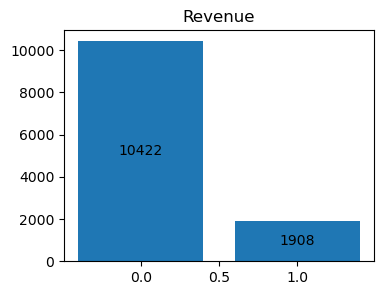

In [263]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

bar = ax.bar(d.keys(),d.values())
ax.set_title('Revenue')
ax.bar_label(bar, label_type='center')
plt.show()

Видим дисбаланс классов - большинство посещений не приводит к покупке
___________

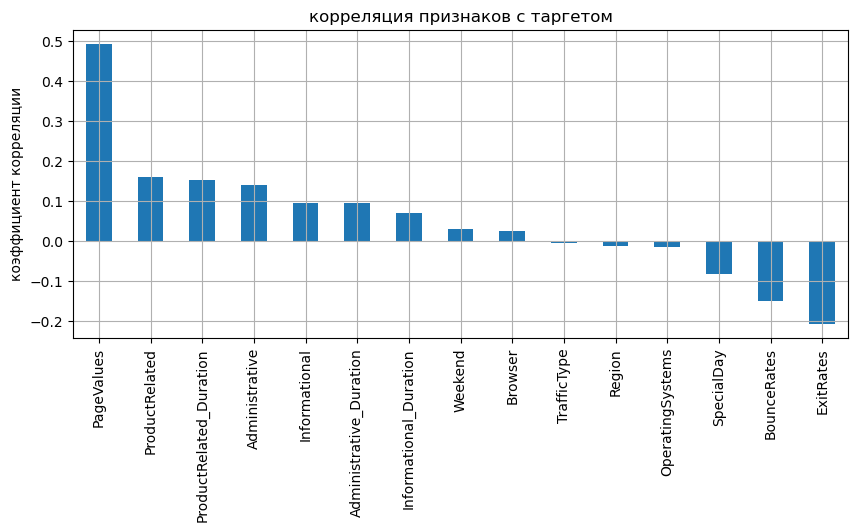

Revenue                    1.000000
PageValues                 0.492569
ProductRelated             0.158538
ProductRelated_Duration    0.152373
Administrative             0.138917
Informational              0.095200
Administrative_Duration    0.093587
Informational_Duration     0.070345
Weekend                    0.029295
Browser                    0.023984
TrafficType               -0.005113
Region                    -0.011595
OperatingSystems          -0.014668
SpecialDay                -0.082305
BounceRates               -0.150673
ExitRates                 -0.207071
Name: Revenue, dtype: float64

In [276]:
correlation = df.corr()['Revenue'].sort_values(ascending=False)

plt.figure(figsize=(10, 4))
correlation.drop('Revenue').plot(kind='bar')
plt.title('корреляция признаков с таргетом')
plt.ylabel('коэффициент корреляции')
plt.grid()
plt.show()

correlation

Наибльшую корреляцию (но все равно достаточно низкую) с Revenue имеет PageValues 
(из названия признака не вполне понятно, что это,
возможно, средний рейтинг по какой-то шкале страниц, посещенных пользователем)

Посмотрим на боксплоты числовых признаков по бинам таргета:

In [313]:
def two_factor_bar(feat1='Revenue', feat2='PageValues'):
    fig = plt.figure(figsize=(8, 3))
    sns.boxplot(df[feat1], df[feat2])
    plt.title(f'{feat1} by {feat2}', fontsize = 10)
    plt.xlabel(feat1,fontsize=10)
    plt.ylabel(feat2,fontsize=10)
    plt.show()
    return

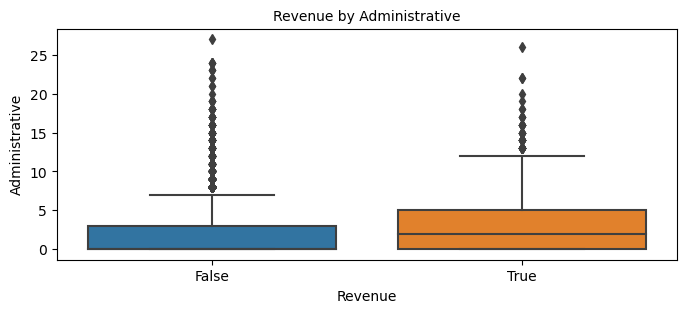

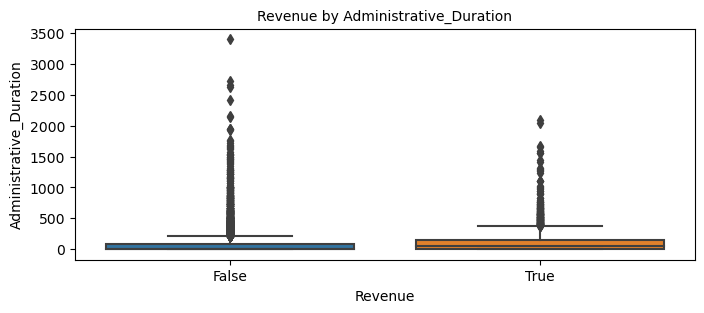

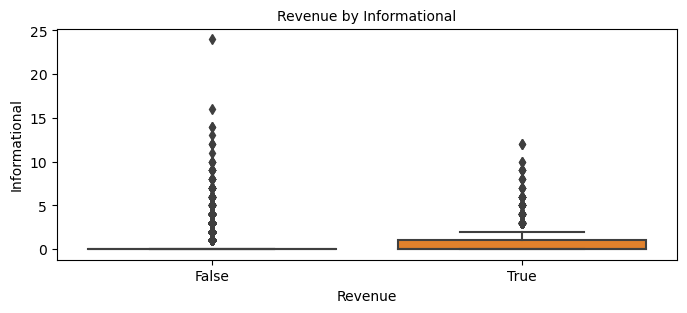

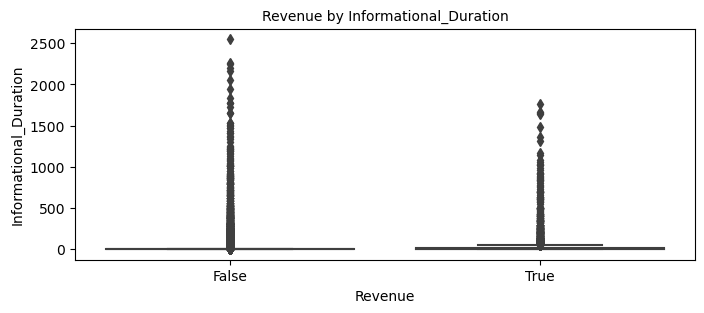

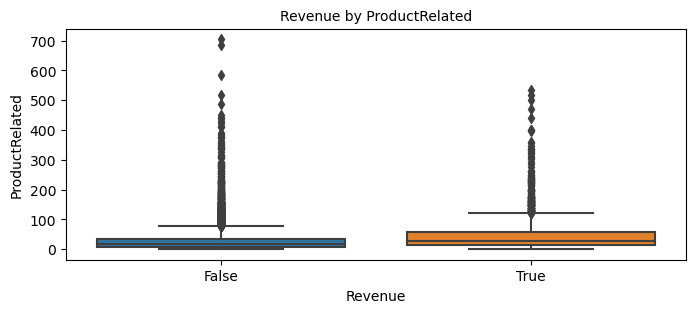

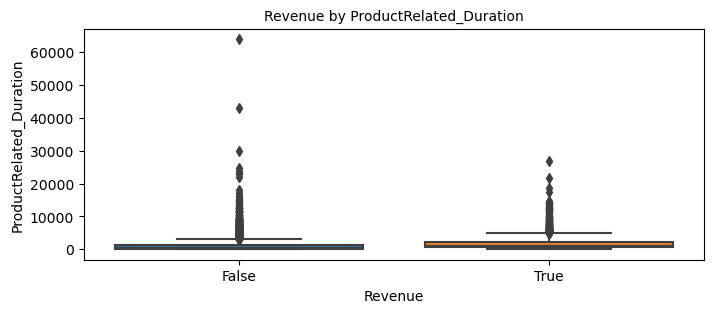

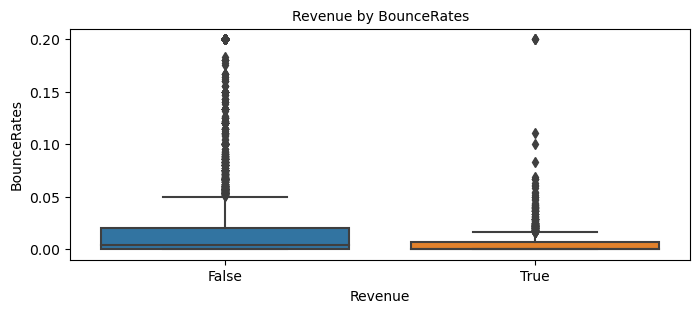

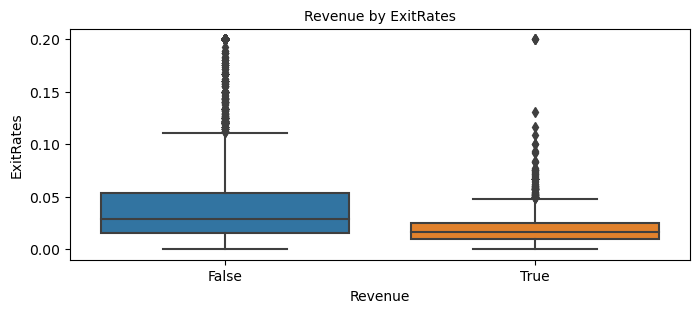

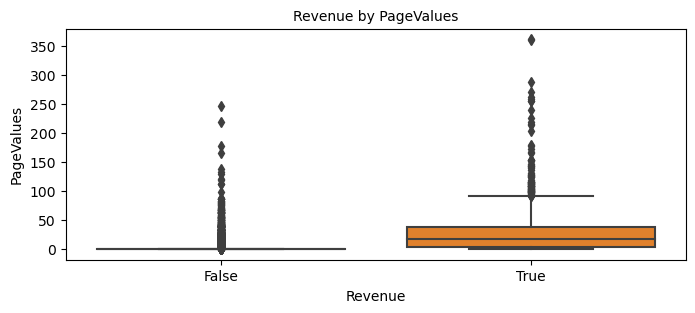

In [314]:
for col in num_features:
    two_factor_bar('Revenue',col)

1_ Пользователи, совершающие покупку в среднем посещают больше административных и информационных страниц
2_ Если у посетителя BounceRate выше 0.025, то он почти наверняка ничего не купит
3_ Если у посетителя BounceRate выше 0.25, то он почти наверняка ничего не купит
4_ Если посетитель открывает страницы с высоким PageValue, то скорее всего что-то купит
(так как до конца непонятно, что такое PageValue, возможно эта зависимость не обладает 
высокой предиктивной ценностью. Например, если страницы с высоким PageValue - это такие страницы 
как форма заказа или страница оплаты, то и так понятно, что пользователь, посетивший такие страницы,
скорее всего совершит покупку)

Постмотрим на относительные частоты наступления целевого события 
при различных значениях категориальных признаков

In [334]:
def cat_plot(feat):
    ctab = pd.crosstab(df[feat], df['Revenue'])
    ctab_ratio = ctab.div(ctab.sum(axis=1), axis=0)
    ctab_ratio.plot(kind='bar', stacked=True, figsize=(8,3))
    plt.title(f'влияние признака {feat} на таргет')
    plt.ylabel('%')
    plt.xticks(rotation=0)
    plt.show()
    return

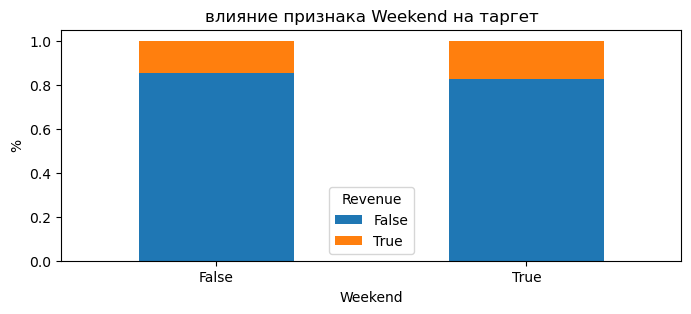

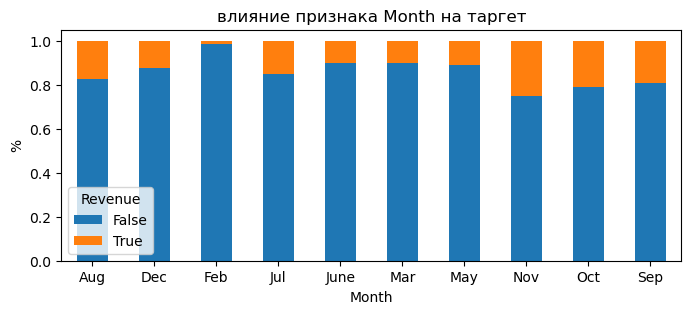

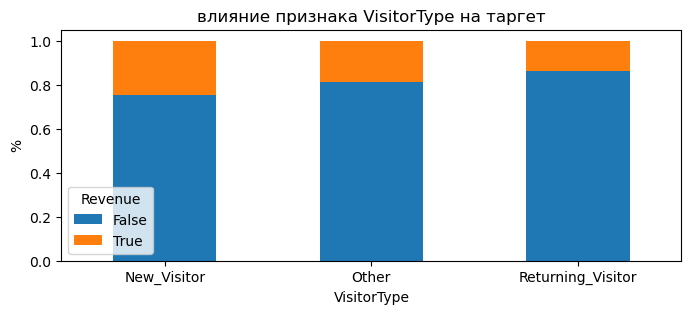

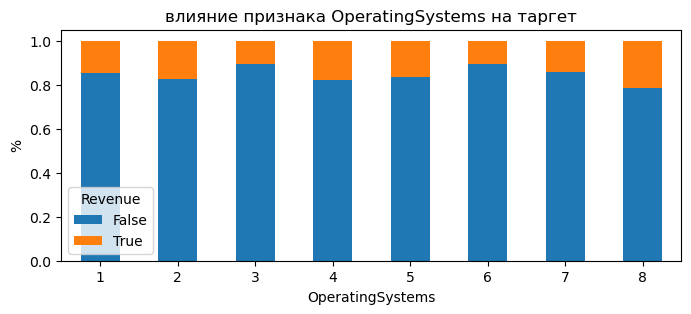

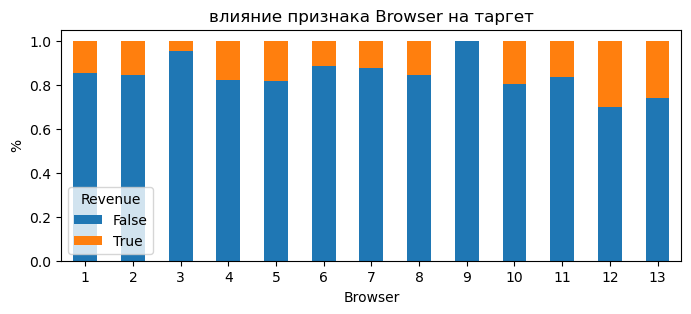

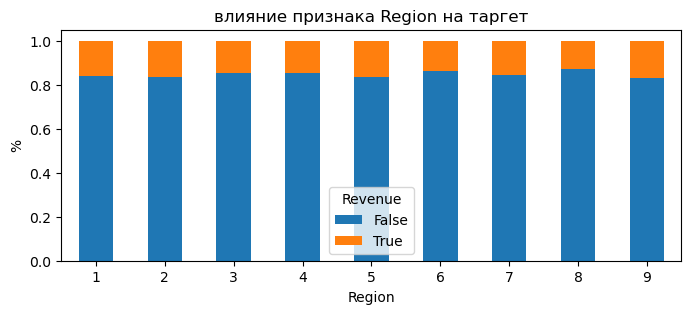

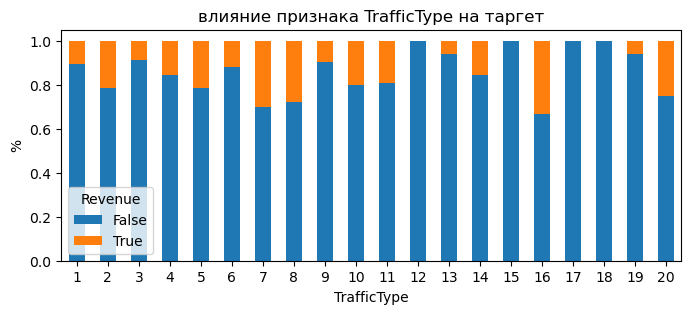

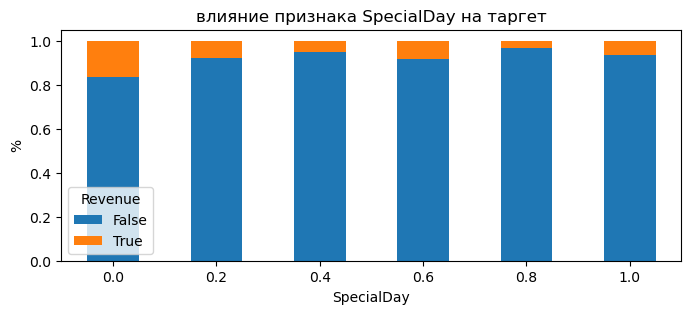

In [336]:
for col in cat_features:
    if col!='Revenue':
        cat_plot(col)

1_ Покупки совершаются в выходные и будни примерно с одинаковой относительной частотой
2_ Практически никогда покупки не совершаются в феврале
3_ Как мы уже отмечали, ноябрь - высокий сезон посещемости, кроме того, видим, что и относительная частота покупок
   в ноябре самая высокая в году
4_ Относительная частота покупок в среднем растет в течение всего года и резко падает в декабре
5_ Новые покупатели покупают чаще, чем возвращающиеся
6_ 9 браузер ярко выделяется (пользователи, заходящие с него никогда не совершают покупок), 
   но это лишь следствие того, что с 9 браузера в принципе заходил лишь 1 посетитель
7_ Во всех регионах покупают с примерно одинаковой относительной частотой
8_ Все еще непонятно, что такое ScecialDay, но при значении 0.0 наблюдается довольно большая конверсия посетителей в
   покупку

Посмотрим на корреляцию признаков

<AxesSubplot:>

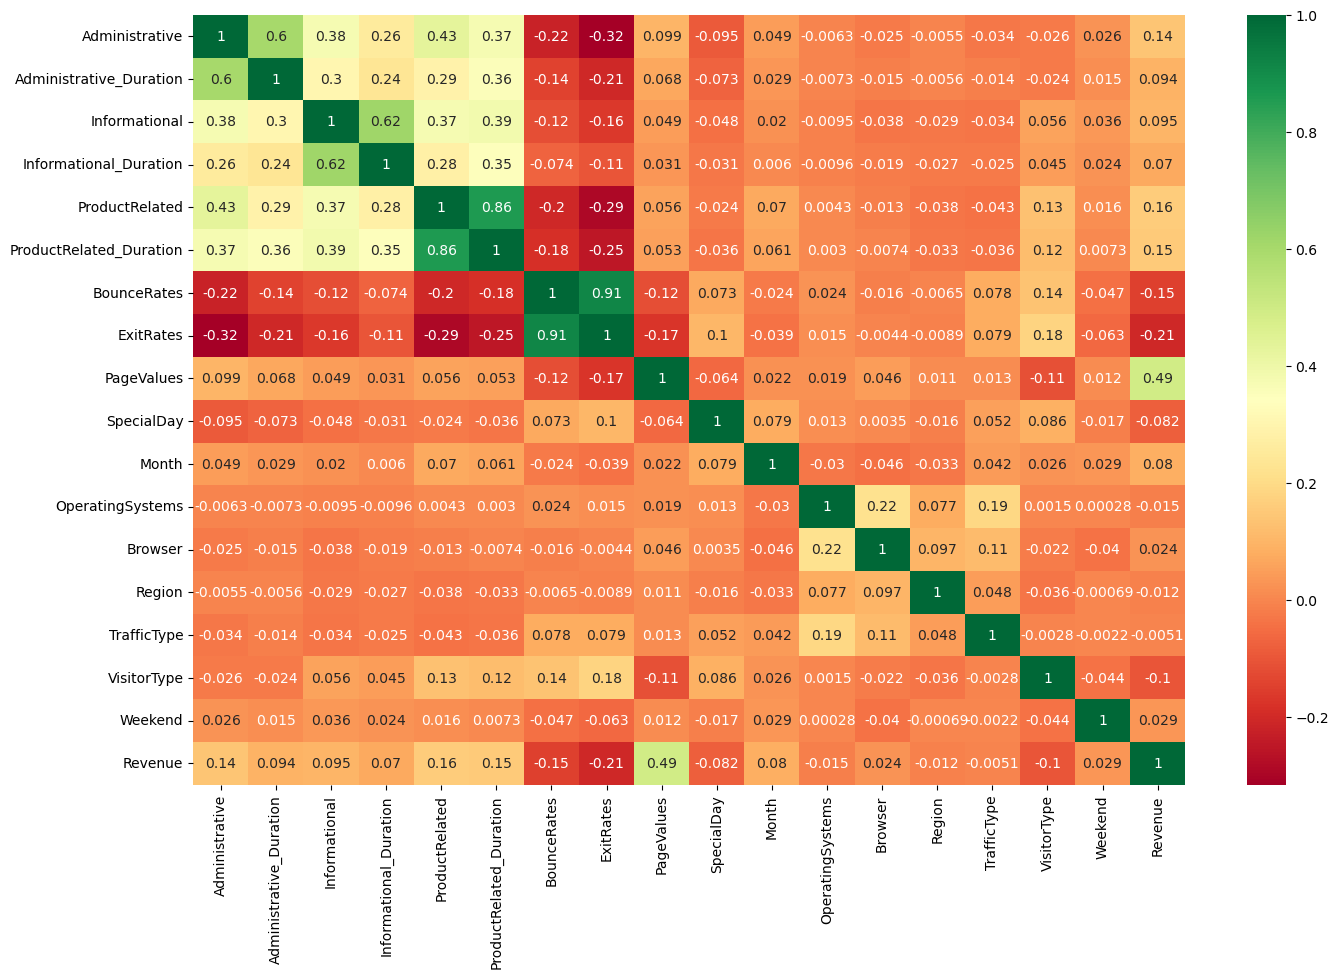

In [140]:
plt.figure(figsize=(16,10))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='RdYlGn')

#### Классификация

In [624]:
dummy_df = pd.get_dummies(df)
le = LabelEncoder()
df['Revenue'] = le.fit_transform(df['Revenue'])

X = dummy_df
y = df['Revenue']

In [625]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = rs)

In [626]:
sScaler = StandardScaler()

X_train = sScaler.fit_transform(X_train)
X_test = sScaler.fit_transform(X_test)

In [631]:
log_regressor = LogisticRegression()

log_regressor.fit(X_train, y_train)
y_pred = log_regressor.predict(X_test)

metrics = classification_report(y_test, y_pred)

In [632]:
print(metrics)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4165
           1       1.00      1.00      1.00       767

    accuracy                           1.00      4932
   macro avg       1.00      1.00      1.00      4932
weighted avg       1.00      1.00      1.00      4932

